In [33]:
import tensorflow as tf
# a = tf.constant([[1, 2], [3, 4]])
# b = tf.constant([[5, 6], [7, 8]])
# ab = tf.matmul(a, b)

# sess = tf.Session()
# sess.run(ab)

In [34]:
# d = tf.constant([[10, 11], [12, 13]])
# ad = tf.add(a, d)

# sess.run(ad)

In [35]:
import numpy as np
np.random.seed(0)

data = np.load("data_with_labels.npz")
train = data["arr_0"] / 255.
labels = data["arr_1"]

print(train[0])
print(labels[0])

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
0


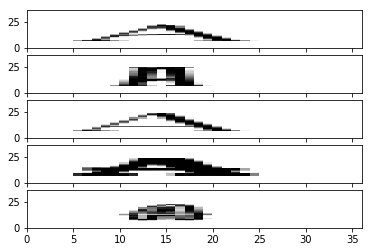

In [36]:
import matplotlib.pyplot as plt
plt.ion()

plt.figure(figsize=(6, 6))
f, plts = plt.subplots(5, sharex=True)

c = 91

for i in range(5):
    plts[i].pcolor(train[c + i * 558], cmap=plt.cm.gray_r)

In [37]:
def to_onehot(labels, nclasses=5):
    outlabels = np.zeros((len(labels), nclasses))
    for i, l in enumerate(labels):
        outlabels[i, l] = 1
    return outlabels

onehot = to_onehot(labels)

In [38]:
indices = np.random.permutation(train.shape[0])
valid_cnt = int(train.shape[0] * 0.1)
test_idx, training_idx = indices[:valid_cnt], indices[valid_cnt:]
test, train = train[test_idx,:], train[training_idx,:]
onehot_test, onehot_train = onehot[test_idx,:], onehot[training_idx,:]

sess = tf.InteractiveSession()

x = tf.placeholder("float", [None, 36 * 36])
y_ = tf.placeholder("float", [None, 5])

W = tf.Variable(tf.zeros([36 * 36, 5]))
b = tf.Variable(tf.zeros([5]))

sess.run(tf.global_variables_initializer())

y = tf.nn.softmax(tf.matmul(x, W) + b)

### End model specification; begin training.

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y + 1e-50, labels=y_))
train_step = tf.train.GradientDescentOptimizer(0.02).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

epochs = 1000

train_acc = np.zeros(epochs // 10)
test_acc = np.zeros(epochs // 10)

for i in range(epochs):
    if i % 10 == 0:
        A = accuracy.eval(feed_dict={
            x: train.reshape([-1, 36 * 36]),
            y_: onehot_train
        })
        train_acc[i // 10] = A
        A = accuracy.eval(feed_dict={
            x: test.reshape([-1, 36 * 36]),
            y_: onehot_test
        })
        test_acc[i // 10] = A
    train_step.run(feed_dict={
        x: train.reshape([-1, 36 * 36]),
        y_: onehot_train
    })
    
print(train_acc[-1])
print(test_acc[-1])

0.384707301855
0.354838699102


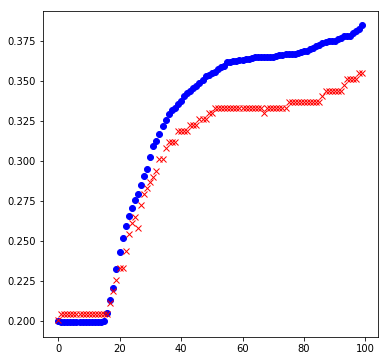

In [40]:
plt.figure(figsize=(6, 6))
plt.plot(train_acc, "bo")
plt.plot(test_acc, "rx")

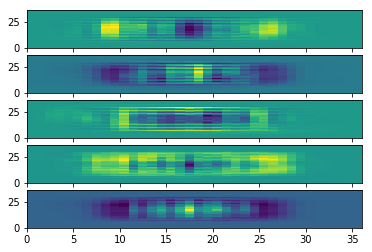

In [43]:
f, plts = plt.subplots(5, sharex=True)
for i in range(5):
    plts[i].pcolor(W.eval()[:,i].reshape([36, 36]))

Time to make a DNN.

In [47]:
import math

x1 = tf.Variable(tf.truncated_normal([5], mean=3, stddev=1./math.sqrt(5)))
x2 = tf.Variable(tf.truncated_normal([5], mean=0, stddev=1./math.sqrt(5)))
x3 = tf.Variable(tf.truncated_normal([5], mean=-1, stddev=1./math.sqrt(5)))

sess.run(tf.global_variables_initializer())

x2x2 = x2 * x2
print(x2.eval())
print(x2x2.eval())

[-0.11735548  0.8436957  -0.06381734  0.72016937 -0.23098052]
[ 0.01377231  0.71182245  0.00407265  0.51864392  0.053352  ]


In [49]:
logx1 = tf.log(x1)

print(x1.eval())
print(logx1.eval())

[ 2.50935411  2.97448373  2.20626354  2.82587671  2.35454512]
[ 0.92002541  1.09007049  0.79130036  1.0388186   0.85634756]


In [51]:
sigx3 = tf.sigmoid(x3)

print(x3.eval())
print(sigx3.eval())

[-1.61565137 -0.62503165 -0.93145192 -0.68860698 -0.76751804]
[ 0.16580547  0.34863794  0.28263023  0.33434305  0.31701624]


In [52]:
w1 = tf.constant(0.1)
w2 = tf.constant(0.2)

sess.run(tf.global_variables_initializer())

print((w1 * x1).eval())
print((w2 * x2).eval())

[ 0.34560835  0.36569992  0.27491722  0.32163629  0.31477684]
[-0.03066652 -0.04971973  0.0139522  -0.1200963   0.0234282 ]


In [54]:
n1 = tf.sigmoid(w1 * x1 + w2 * x2)
print(n1.eval())

[ 0.57809103  0.57834429  0.57171935  0.55021513  0.58375442]


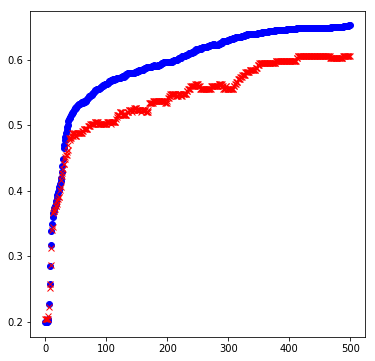

In [59]:
# add a hidden layer
num_hidden = 128
W1 = tf.Variable(tf.truncated_normal([36 * 36, num_hidden], stddev=1./math.sqrt(36 * 36)))
b1 = tf.Variable(tf.constant(0.1, shape=[num_hidden]))
h1 = tf.sigmoid(tf.matmul(x, W1) + b1)

W2 = tf.Variable(tf.truncated_normal([num_hidden, 5], stddev=1./math.sqrt(5)))
b2 = tf.Variable(tf.constant(0.1, shape=[5]))

sess.run(tf.global_variables_initializer())

y = tf.nn.softmax(tf.matmul(h1, W2) + b2)

### end spec, begin train

# this code, again
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y + 1e-50, labels=y_))
train_step = tf.train.GradientDescentOptimizer(0.02).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

epochs = 5000

train_acc = np.zeros(epochs // 10)
test_acc = np.zeros(epochs // 10)

for i in range(epochs):
    if i % 10 == 0:
        A = accuracy.eval(feed_dict={
            x: train.reshape([-1, 36 * 36]),
            y_: onehot_train
        })
        train_acc[i // 10] = A
        A = accuracy.eval(feed_dict={
            x: test.reshape([-1, 36 * 36]),
            y_: onehot_test
        })
        test_acc[i // 10] = A
    train_step.run(feed_dict={
        x: train.reshape([-1, 36 * 36]),
        y_: onehot_train
    })
    
plt.figure(figsize=(6, 6))
plt.plot(train_acc, "bo")
plt.plot(test_acc, "rx")

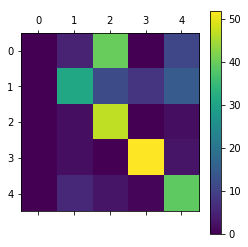

In [62]:
pred = np.argmax(y.eval(feed_dict={
    x: test.reshape([-1, 36 * 36]),
    y_: onehot_test
}), axis=1)
conf = np.zeros([5, 5])

for p, t in zip(pred, np.argmax(onehot_test, axis=1)):
    conf[t, p] += 1
    
plt.matshow(conf)
plt.colorbar()

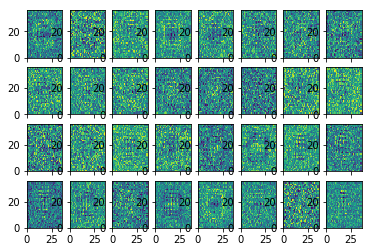

In [63]:
plt.figure(figsize=(6, 6))
f, plts = plt.subplots(4, 8, sharex=True)

for i in range(32):
    plts[i // 8, i % 8].pcolormesh(W1.eval()[:,i].reshape([36, 36]))